# Midterm Project (Data processing and Data Exploration)

## Introduction

Provide background on your dataset and a clear formulated question or hypothesis
- Formulated Question: Is text generated by LLM (i.e. chatGPT) has biased sentiment when prompted to give an opinion on certain topics.
- Dataset to be used "Public Opinion on NASA's Climate Posts on Facebook" from Kaggle.
- For this project, we will first preprocess and extract important feature from the text data in the above dataset. Next, we will train machine learning model predicting sentiment of a given input text in "positive", "neutral", and "negative" classes. The final goal of the project is to train a classification model on the dataset above and make prediction on the set of texts generated by LLM such as chatGPT when prompted to give an opinion on NASA's Climate Posts.
- The motivation to this project is to find out how biased or not biased LLM is when prompted to give opinons on certain topics.

## Methods

Include how and where the data were acquired, how you cleaned and wrangled the data, what
tools you used for data exploration 

In [1]:
# Configuration
from traitlets.config import Config
import nbformat as nbf
from nbconvert.exporters import HTMLExporter
from nbconvert.preprocessors import TagRemovePreprocessor

# Setup config
c = Config()

# Configure tag removal - be sure to tag your cells to remove  using the
# words remove_cell to remove cells. You can also modify the code to use
# a different tag word
c.TagRemovePreprocessor.remove_cell_tags = ("remove_cell",)
c.TagRemovePreprocessor.remove_all_outputs_tags = ("remove_output",)
c.TagRemovePreprocessor.remove_input_tags = ("remove_input",)
c.TagRemovePreprocessor.enabled = True

# Configure and run out exporter
c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

exporter = HTMLExporter(config=c)
exporter.register_preprocessor(TagRemovePreprocessor(config=c), True)

# Configure and run our exporter - returns a tuple - first element with html,
# second with notebook metadata
output = HTMLExporter(config=c).from_filename("midterm_project.ipynb")

# Write to output html file
with open("midterm_project.html", "w") as f:
    f.write(output[0])

In [3]:
# Imports 
import numpy as np
import pandas as pd 

import sys
import argparse
import os
import json
import re
import spacy
import html
!pip install spacy_ngram
import en_core_web_sm
from spacy_ngram import NgramComponent
import nltk
from nltk.util import ngrams
nlp = spacy.load('en_core_web_sm') # need `python -m spacy download en` on terminal
nlp.add_pipe('sentencizer')
nlp.add_pipe('spacy-ngram')

from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# Additional imports and define some necessary lists

import string
FIRST_PERSON_PRONOUNS = {
    'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours'}
SECOND_PERSON_PRONOUNS = {
    'you', 'your', 'yours', 'u', 'ur', 'urs'}
THIRD_PERSON_PRONOUNS = {
    'he', 'him', 'his', 'she', 'her', 'hers', 'it', 'its', 'they', 'them',
    'their', 'theirs'}
SLANG = {
    'smh', 'fwb', 'lmfao', 'lmao', 'lms', 'tbh', 'rofl', 'wtf', 'bff',
    'wyd', 'lylc', 'brb', 'atm', 'imao', 'sml', 'btw', 'bw', 'imho', 'fyi',
    'ppl', 'sob', 'ttyl', 'imo', 'ltr', 'thx', 'kk', 'omg', 'omfg', 'ttys',
    'afn', 'bbs', 'cya', 'ez', 'f2f', 'gtr', 'ic', 'jk', 'k', 'ly', 'ya',
    'nm', 'np', 'plz', 'ru', 'so', 'tc', 'tmi', 'ym', 'ur', 'u', 'sol', 'fml'}

COMMON_NOUNS = {"NN", "NNS"}
PROPER_NOUNS = {"NNP", "NNPS"}
FUTURE_TENSE = {"'\ll", "will", "gonna"}
ADVERBS = {"RB", "RBR", "RBS"}
WH_WORDS = {"WDT", "WP", "WP$", "WRB"}

mc_punctuation = list(string.punctuation)

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}
add_slang = abbreviations.keys()
slang = list(SLANG) + list(add_slang)

## Read in data as datframe and preprocess

First, we read in the "Public Opinion on NASA's Climate Posts on Facebook" dataset as a pandas dataframe. For this part of the report, python libraries such as `numpy`, `pandas`, `spacy`, `re` (regular expression) and `html` were used to read in and preprocess the data. The original dataframe contains columns, "date", "likesCount", "commentsCount", and "text". For "commentsCount" column, all the NA values are converted to zeros. Then, we created 18 additional columns, extracting important features from the given text data. By using the function `preprocess()`, the data in "text" column was preprocessed by removing redundant spaces, unnecessary characters and adding parts of speech tagging to each token (after tokenizing). The relevant features of the text data was retrived `extract()` function that returns a numpy array of length 17, where each element in the array corresponds to certain features such as "num_first_pronoun" (number of first-person pronouns in a string) and "avg_len_sen" (Average length of a sentence in tokens). The dexcription of each column is below.

- date: date of when the comment was made on post
- likesCount: the number of likes to the comment
- commentsCount: the number of comments to the comment
- text: raw comment text
- text_processed: preprocessed text
- num_uppercase: the number of upper case 
- num_first_pronoun: the number of first-person pronouns
- num_second_pronoun: the number of second-person pronouns
- num_third_pronoun: the number of third-person pronouns
- num_coord_conj: the number of coordinating conjunctions
- num_past_verb: the number of past-tense verbs
- num_future_verb: the number of future-tense verbs
- num_comma:  the number of commas
- num_multi_punc: the number of multi-character punctuation tokens
- num_common_noun: the number of common nouns
- num_proper_noun: the number of proper nouns
- num_adverb: the number of adverbs
- num_wh: the number of 'wh-' words
- num_slang: the number of slang acronyms
- avg_len_sen: the average length of setences in tokens
- avg_len_token: the average length of tokens, exlcluding punctuation-only tokens in characters
- num_sen: the number of sentences
- bigram: bigram token of text

In [9]:
# Import data
original_df = pd.read_csv("train.csv")
# Choose necessary columns 
original_df = original_df[["TITLE", "TARGET_ENTITY", "DOCUMENT", "TRUE_SENTIMENT"]]
# # Change NA values in column, "commentsCount" to be zeros
# original_df["commentsCount"] = original_df["commentsCount"].fillna(0)
original_df.shape

(3355, 4)

In [7]:
# Remove all non-english text - We don't need this for new dataset
!pip install langdetect
import langdetect
from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        # If language detection fails (e.g., for short strings), assume it's not English
        return False
    
# Filter out non-English strings
original_df['is_eng'] = original_df['DOCUMENT'].apply(lambda x: is_english(x))
original_df = original_df.loc[original_df.is_eng == True]
# original_df.shape #(435, 7)
original_df = original_df.dropna(subset=['DOCUMENT'], ignore_index=True)
original_df.head(50)

,TITLE,TARGET_ENTITY,DOCUMENT,TRUE_SENTIMENT,is_eng
0,German bank LBBW wins EU bailout approval,Landesbank Baden Wuertemberg,Germany's Landesbank Baden Wuertemberg won EU ...,Negative,True
1,8th LD Writethru: 9th passenger released from ...,Rolando Mendoza,The Philippine National Police (PNP) identifie...,Neutral,True
2,Commission: Bar Liberian president from office,Charles Taylor,Sirleaf 70 acknowledged before the commissio...,Negative,True
3,AP Exclusive: Network flaw causes scary Web error,Sawyers,Sawyer logged off and asked her sister Mari ...,Neutral,True
4,Holyfield ' s wife says boxer hit her several ...,Candi Holyfield,Candi Holyfield said in the protective order t...,Neutral,True
5,Hillary Clinton : Misogyny is ` endemic ' .,Hillary Clinton,-LRB- CNN -RRB- Hillary Clinton slammed what s...,Neutral,True
6,Trouser-wearing women fined $200 in Sudan,Lubna Hussein,Lubna Hussein was among 13 women arrested July...,Neutral,True
7,Hillary Clinton Compares Donald Trump With Har...,Hillary Clinton,"""A lot of people thought I was probably exagge...",Neutral,True
8,"Feature: ""Chinese is an important part of my l...",Maria Rukodelnikova,Rukodelnikova is fond of a lot things from Chi...,Positive,True
9,Former Australian Opposition leader attacks ne...,Tony Abbott,Former Australian Opposition leader Malcolm Tu...,Neutral,True


In [10]:
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Get the English stopwords
english_stopwords = set(stopwords.words('english'))
english_stopwords = list(english_stopwords)
print(english_stopwords)

['from', 'off', "should've", 'very', 'so', 'because', 'most', 'don', 'now', 'm', 'then', 'the', 'before', "you've", 'these', 'o', 'he', 'mightn', 'wasn', 'shouldn', 'doing', "that'll", 'it', 'll', 'been', 'if', 'we', 'd', 'her', 'itself', 'more', 'won', 'just', 'isn', 'ain', "it's", 'do', 'does', 'are', 'than', 'a', 'through', 'you', "needn't", 'as', 'against', 'have', 'your', 'herself', 'that', 'in', 'am', 'were', 'no', 'our', 'themselves', 'such', 'this', 'again', 'ma', 'his', 'himself', 'hasn', 'doesn', 'what', 'wouldn', 'each', 've', 'couldn', 'which', 'an', 'will', 'for', 'their', 'over', 'shan', 'other', 'weren', 'here', 'she', 'once', 'some', 'while', 'yours', 'between', 'why', 'was', 'me', "she's", 'yourselves', 'having', 'him', "haven't", "you're", 'into', "mustn't", 'whom', 'has', 'or', 'by', 'they', 'had', "hasn't", 'out', 'after', 'hers', 'didn', 'about', 'haven', 'with', 'same', 'did', "you'd", 'i', 'its', "couldn't", 'being', 'mustn', 'yourself', 'few', "hadn't", "doesn't

[nltk_data] Downloading package stopwords to /opt/conda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Process text data
def remove_emojis(text):
    # Define a regular expression pattern to match emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    # Remove emojis from the text using the pattern
    return emoji_pattern.sub(r'', text)

def preprocess(comment):
    """ 
    This function preprocesses a single comment.

    Parameters:                                                                      
    - comment: string, the body of a comment.

    Returns:
    - modified_comment: string, the modified comment with parts of speech tagging
    """
    modified_comment = comment
    
    modified_comment = re.sub(r"\n{1,}", " ", modified_comment)
    modified_comment = re.sub(r"\t{1,}", " ", modified_comment)
    modified_comment = re.sub(r"\r{1,}", " ", modified_comment)
    modified_comment = re.sub(r"\s{1,}", " ", modified_comment)

    modified_comment = re.sub(r"\[deleted\]|\[removed\]{1,}", "", modified_comment)

    modified_comment = html.unescape(modified_comment)
    modified_comment = re.sub(r"(http|www)\S+", "", modified_comment)

    modified_comment = re.sub(r"\s+", " ", modified_comment)
    modified_comment = remove_emojis(modified_comment)
    
    return modified_comment

def pos_tagging(comment):
    """
    This function assigns parts of speech tagging to a single comment
    """

    document = nlp(comment)
    result = ""
    
    # parts of speech tagging
    for sent in document.sents:
        sentence = ""
        for token in sent:
            word = token.lemma_
            if (word.startswith("-")) and (not token.text.startswith("-")):
                word = token.text
            if token.text.isupper():
                word = token.text
            word = word + "/" + token.tag_ + " "
            sentence += word
        result += "".join([sentence])
        result += "\n"

    return result

def bigram(comment):
    modified_comment = re.sub(r"\n{1,}", " ", comment)
    modified_comment = re.sub(r"\t{1,}", " ", modified_comment)
    modified_comment = re.sub(r"\r{1,}", " ", modified_comment)
    modified_comment = re.sub(r"\s{1,}", " ", modified_comment)

    modified_comment = re.sub(r"\[deleted\]|\[removed\]{1,}", "", modified_comment)

    modified_comment = html.unescape(modified_comment)
    modified_comment = re.sub(r"(http|www)\S+", "", modified_comment)

    modified_comment = re.sub(r"\s+", " ", modified_comment)

    document = nlp(modified_comment)
    return document._.ngram_2

def extract(comment):
    """ 
    This function extracts features from a single comment.

    Parameters:
    - comment: string, the body of a comment (after preprocessing).

    Returns:
    - feats: NumPy Array, a 16-length vector of floating point features.
    """    
    result = np.zeros(17, dtype=np.float32)
    # Extract features that rely on capitalization
    error = []
    comment_list = comment.split(" ")
    text_only = []
    pos_only = []

    for word in comment_list:
        token = word.split("/")
        if len(token) == 2:
          text_only.append(token[0].strip("\n"))
          pos_only.append(token[1].strip("\n"))
        else:
          error.append(token)
    
    # feature 1 - number of tokens in upper case (>=3 letters long)
    text_lower = []
    for token in text_only:
        token = token.strip("\n")
        if token.isupper() and len(token) >= 3:
            result[0] += 1
        text_lower.append(token.lower().strip("\n"))
            
    # Extract features that do not rely on capitalization
    # Feature 2-14
    for i in range(len(text_lower)):
      # feature 2 - number of first-person pronouns
      if text_lower[i] in FIRST_PERSON_PRONOUNS:
        result[1] += 1
      # feature 3 - second-person pronouns
      if text_lower[i] in SECOND_PERSON_PRONOUNS:
        result[2] += 1
      # feature 4 - third-person pronouns
      if text_lower[i] in THIRD_PERSON_PRONOUNS:
        result[3] += 1
      # feature 5 - number of coordinating conjunctions
      if pos_only[i] == "CC":
        result[4] += 1
      # feature 6 - number of past-tense verbs
      if pos_only[i] == "VBD":
        result[5] += 1
      # feature 7 - number of future-tense verbs
      if text_lower[i] in FUTURE_TENSE:
        result[6] += 1
      if (text_lower[i] == "going") and (text_lower[i+1] == "to") and (pos_only[i] == "VB"):
        result[6] += 1
      # feature 8 - number of commas
      if text_lower[i] == ",":
        result[7] += 1
      # feature 9 - number of multi-caharacter punctuation tokens
      for char in text_lower[i]:
        if char in mc_punctuation:
          result[8] += 1
      # feature 10  - number of common nouns
      if pos_only[i] in COMMON_NOUNS:
        result[9] += 1
      # feature 11 - number of proper nouns
      if pos_only[i] in PROPER_NOUNS:
        result[10] += 1
        # feature 12 - number of adverbs
      if pos_only[i] in ADVERBS:
        result[11] += 1
        # feature 13
      if pos_only[i] in WH_WORDS:
        result[12] += 1
        # feature 14 - number of slang acronyms
      if pos_only[i] in slang:
        result[13] += 1
    # Feature 15 - 17
    
    # feature 15 avg length of sentences, in tokens
    sent_list = (comment.strip()).split("\n")
    avg = 0
    count = 0
    for sent in sent_list:
      sent_list = (sent.strip()).split(" ")
      avg += len(sent_list)
      count += 1
    result[14] = avg / count if count != 0 else float(0)
    
    
    # feature 16 - avg length of tokens, excluding punctuation-only tokens, in characters
    avg_token = 0
    count_token = 0
    for token in text_lower:
      if not (token in mc_punctuation):
        avg_token += len(token)
        count_token += 1
    result[15] = avg_token / count_token if count_token != 0 else float(0)
    
    # feature 17 - number of sentence
    result[16] = count
    
#     feat_col = ['num_uppercase', 'num_first_pronoun', 'num_second_pronoun', 'num_third_pronoun', 'num_coord_conj', 'num_past_verb', 'num_future_verb', 'num_comma', 'num_multi_punc', 'num_common_noun', 'num_proper_noun', 'num_adverb', 'num_wh', 'num_slang', 'avg_len_sen', 'avg_len_token', 'num_sen']
#     result_df = pd.DataFrame(result)
    
    return result

def get_bigram(text):
    big=''
    token = nltk.word_tokenize(text)
    big=(list(ngrams(token, 2)))
    return str(big)

def tfidf_vectorize(docs):
    """
    Input: a list of strings
    Output: vectorized matrix
    """
    document = df['text_cleaned'].tolist()
    lem_list = []
    for text in document:
        doc = nlp(text)
        lem_text = " ".join([token.lemma_ for token in doc])
        lem_list.append(lem_text)
    
    input_list = []
    for text in docs:
        doc = nlp(text)
        lem_text = " ".join([token.lemma_ for token in doc])
        input_list.append(lem_text)
    
    # initialize an instance of TfidfVectorizer
    vectorizer = TfidfVectorizer(max_features=200, stop_words=english_stopwords)

    # fit and transform the text data using the TfidfVectorizer
    vectorizer.fit(lem_list)
    tfidf = vectorizer.transform(input_list)
    
    tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())
    return tfidf_df

In [12]:
# Preprocess text data using the above function
original_df["DOCUMENT"] = original_df["DOCUMENT"].astype(str)
original_df["text_cleaned"] = original_df["DOCUMENT"].apply(lambda x: preprocess(x))
print('Cleaned text')
original_df["text_processed"] = original_df["text_cleaned"].apply(lambda x: pos_tagging(x))
print('POS tagging')
feat_col = ['num_uppercase', 'num_first_pronoun', 'num_second_pronoun', 'num_third_pronoun', 'num_coord_conj', 'num_past_verb', 'num_future_verb', 'num_comma', 'num_multi_punc', 'num_common_noun', 'num_proper_noun', 'num_adverb', 'num_wh', 'num_slang', 'avg_len_sen', 'avg_len_token', 'num_sen']

new_array = np.array([extract(text) for text in original_df['text_processed'].values])
new_df = pd.DataFrame(new_array, columns=feat_col)

df = pd.concat([original_df, new_df], axis=1)
# df['bigram'] = df['text'].apply(bigram) 

# convert text to tfidf
document = df['text_cleaned'].tolist()
tfidf_df = tfidf_vectorize(document)
final_df = pd.concat([df, tfidf_df], axis=1)
print("TFIDF vectorized")
print(final_df) # (3355, 273)

Cleaned text
POS tagging
TFIDF vectorized
                                                  TITLE  \
0             German bank LBBW wins EU bailout approval   
1     8th LD Writethru: 9th passenger released from ...   
2        Commission: Bar Liberian president from office   
3     AP Exclusive: Network flaw causes scary Web error   
4     Holyfield ' s wife says boxer hit her several ...   
...                                                 ...   
3350             Man faces death penalty for killing ex   
3351  Michael Wolff: Author denies Trump's claims th...   
3352  Emmerson Mnangagwa a 'tyrant' in line to lead ...   
3353  Potent Cocktail Of Drama And Documentary Explo...   
3354  NBC fires Matt Lauer over 'inappropriate sexua...   

                     TARGET_ENTITY  \
0     Landesbank Baden Wuertemberg   
1                  Rolando Mendoza   
2                   Charles Taylor   
3                          Sawyers   
4                  Candi Holyfield   
...                  

In [28]:
# Convert the DataFrame to a CSV file
file_path = 'author_sentiment.csv'
final_df.to_csv(file_path, index=False)

In [9]:
# Assign sentiment label - we dont need this for new dataset
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

sentiment_analyzer = SentimentIntensityAnalyzer()
label = {'neg': [], 'neu': [], 'pos': [], 'class': []}

i = 0 
for text in final_df['text_cleaned'].values:
    sentiment = sentiment_analyzer.polarity_scores(text)
    sentiment.pop('compound')
    label['neg'].append(sentiment['neg'])
    label['neu'].append(sentiment['neu'])
    label['pos'].append(sentiment['pos'])
    max_key = max(sentiment, key=lambda k: sentiment[k])
    label['class'].append(max_key)

label_df = pd.DataFrame.from_dict(label)
final_df = pd.concat([final_df, label_df], axis=1)
final_df.head(10)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /opt/conda/nltk_data...


,date,likesCount,commentsCount,text,is_eng,text_cleaned,text_processed,num_uppercase,num_first_pronoun,num_second_pronoun,...,with,world,would,year,you,your,neg,neu,pos,class
0,2022-09-07T17:12:32.000Z,2,0.0,Neat comparison I have not heard it before.\n ...,True,Neat comparison I have not heard it before. I ...,neat/JJ comparison/NN I/PRP have/VBP not/RB he...,1.0,3.0,0.0,...,0.220972,0.0,0.245044,0.0,0.000000,0.0,0.045,0.718,0.237,neu
1,2022-09-08T14:51:13.000Z,0,0.0,An excellent way to visualise the invisible! T...,True,An excellent way to visualise the invisible! T...,an/DT excellent/JJ way/NN to/TO visualise/VB t...,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.465,0.535,pos
2,2022-09-07T17:19:41.000Z,1,3.0,Does the CO2/ghg in the troposphere affect the...,True,Does the CO2/ghg in the troposphere affect the...,do/VBZ the/DT CO2/NNP //SYM ghg/NNP in/IN the/...,1.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.854,0.146,neu
3,2022-09-08T00:51:30.000Z,4,0.0,excellent post! I defo feel the difference - o...,True,excellent post! I defo feel the difference - o...,excellent/JJ post/NN !/. \nI/PRP defo/VBP feel...,0.0,3.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.155,0.658,0.187,neu
4,2022-09-07T19:06:20.000Z,16,26.0,"Yes, and carbon dioxide does not harm the Eart...",True,"Yes, and carbon dioxide does not harm the Eart...","yes/UH ,/, and/CC carbon/NN dioxide/NN do/VBZ ...",0.0,0.0,1.0,...,0.000000,0.0,0.000000,0.0,0.203802,0.0,0.100,0.642,0.258,neu
5,2022-09-15T17:10:57.000Z,4,1.0,Excellent example...very relatable to the Gen ...,True,Excellent example...very relatable to the Gen ...,excellent/JJ example/NN .../: very/RB relatabl...,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.748,0.252,neu
6,2022-09-07T17:31:25.000Z,10,0.0,I am so proud of whoever created this content....,True,I am so proud of whoever created this content....,I/PRP be/VBP so/RB proud/JJ of/IN whoever/WP c...,0.0,1.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.518,0.482,neu
7,2022-09-07T18:07:53.000Z,1,21.0,Has the Earth ever had a concentration of over...,True,Has the Earth ever had a concentration of over...,have/VBZ the/DT Earth/NNP ever/RB have/VBD a/D...,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,1.000,0.000,neu
8,2022-09-07T22:45:56.000Z,0,0.0,"Yes, and not even half a cup later that poor s...",True,"Yes, and not even half a cup later that poor s...","yes/UH ,/, and/CC not/RB even/RB half/PDT a/DT...",0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.165,0.691,0.144,neu
9,2022-09-07T16:30:55.000Z,4,8.0,Historical co2 data would make it an interesti...,True,Historical co2 data would make it an interesti...,historical/JJ co2/NN datum/NNS would/MD make/V...,0.0,0.0,0.0,...,0.000000,0.0,0.395086,0.0,0.000000,0.0,0.000,0.748,0.252,neu


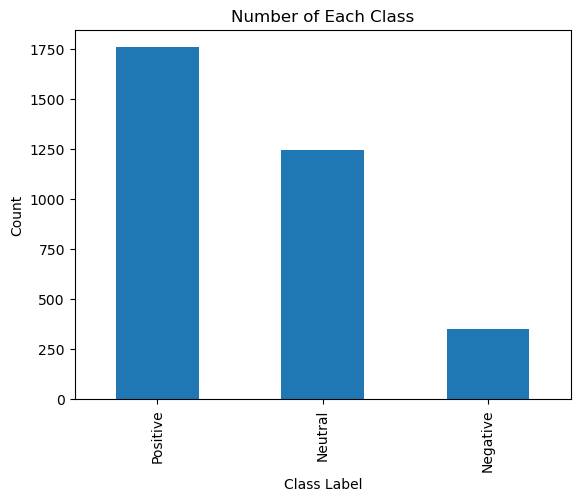

In [12]:
import matplotlib.pyplot as plt
# Count the occurrences of each class label
class_counts = final_df['TRUE_SENTIMENT'].value_counts()

# Plot the counts using a bar graph
class_counts.plot(kind='bar')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Number of Each Class')
plt.show()

In [13]:
# POS demostration
print(pos_tagging("This is an example text."))

this/DT be/VBZ an/DT example/NN text/NN ./. 



## Data Exploration

In here, we checked for data dimentsion, NA values in the dataframe and datatypes for each column.

- The dataframe contains 522 rows and 22 columns.
- There is no NA values in any of the columns in this dataset.
- Expect for "date", "text", and "text_processed" columns, the datatypes of numerical columns are `float32`.

In [30]:
print(f'The size of the dataframe: {final_df.shape}')
print(f'The number of NA values:\n {final_df.isnull().sum()}')
print(f'The data types of the dataframe:\n{final_df.dtypes}')

The size of the dataframe: (3355, 223)
The number of NA values:
 TITLE             15
TARGET_ENTITY      0
DOCUMENT           0
TRUE_SENTIMENT     0
text_cleaned       0
                  ..
would              0
write              0
year               0
york               0
young              0
Length: 223, dtype: int64
The data types of the dataframe:
TITLE              object
TARGET_ENTITY      object
DOCUMENT           object
TRUE_SENTIMENT     object
text_cleaned       object
                   ...   
would             float64
write             float64
year              float64
york              float64
young             float64
Length: 223, dtype: object


# Preliminary Results

Provide summary statistics in tabular form and publication-quality figures, take a
look at the kable function from knitr to write nice tables in Rmarkdown.

## Summary statistics of numerical columns

The below shows the summary statistics outlining count, mean, standard deviation, minimum value, 25% percentile, 50% percentile, 75% percentile, and maximum value for each numerical columns in the dataframe. Although some columns like, "num_uppercase" and "num_second_pronoun" have relatively small values, values in the other columns seem to be reasonable.

_Key Finding From the Summary Statistics_

- The mean of number of slang used in the text is very low and the maximum value for this 5, so it is likely the set of slangs used is not adequately capturing the use of slangs.
- The mean number of first-person pronouns is the highest among other types of pronoun (i.e. second-person, third-person), indicating it's likely that the these comments data are expressing one's opinions or feelings towards NASA's climate change posts on Facebook.

In [14]:
# Summary statistics 
# Get summary statistics using describe()
col =  feat_col
stats_df = final_df[col]
summary_stats = stats_df.describe()
summary_stats

,num_uppercase,num_first_pronoun,num_second_pronoun,num_third_pronoun,num_coord_conj,num_past_verb,num_future_verb,num_comma,num_multi_punc,num_common_noun,num_proper_noun,num_adverb,num_wh,num_slang,avg_len_sen,avg_len_token,num_sen
count,3354.000000,3354.000000,3354.000000,3354.000000,3354.000000,3354.000000,3354.000000,3354.000000,3354.000000,3354.000000,3354.000000,3354.000000,3354.000000,3354.000000,3354.000000,3354.000000,3354.000000
mean,3.237627,3.982707,1.093918,14.455277,10.087955,17.802326,0.843769,1.150268,37.764759,67.132080,46.644009,14.825283,5.262671,0.372093,23.906673,4.542656,16.980024
std,16.755373,7.850293,3.388852,17.410769,12.665923,23.645983,1.441174,13.427828,70.296844,76.810722,59.793148,19.275240,6.762351,1.321304,5.939850,0.324017,25.118782
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,8.000000,3.517401,1.000000
25%,0.000000,0.000000,0.000000,6.000000,4.000000,7.000000,0.000000,0.000000,17.000000,33.000000,23.000000,6.000000,2.000000,0.000000,19.913949,4.324753,8.000000
50%,1.000000,2.000000,0.000000,10.000000,7.000000,13.000000,0.000000,0.000000,27.000000,50.500000,35.000000,11.000000,4.000000,0.000000,23.428572,4.547514,12.000000
75%,3.000000,5.000000,1.000000,18.000000,12.000000,22.000000,1.000000,0.000000,43.750000,80.000000,56.000000,19.000000,7.000000,0.000000,27.282468,4.749019,20.000000
max,643.000000,212.000000,80.000000,434.000000,269.000000,507.000000,24.000000,418.000000,2317.000000,1565.000000,1460.000000,494.000000,128.000000,33.000000,72.000000,6.041667,713.000000


## Plots
In this section, most of the plots are generated using python libraries such as `matplotlib`, `wordcloud`, and `pandas`.

### Count for each numerical columns
The collection of histogram plots below are frequency count for each numerical column in the dataframe. Notice from the below plot that almost all columns have very high frequencies for small values, and they are right-skewed. For later development of machie learing models, we might want to correct the skewness of this dataset.

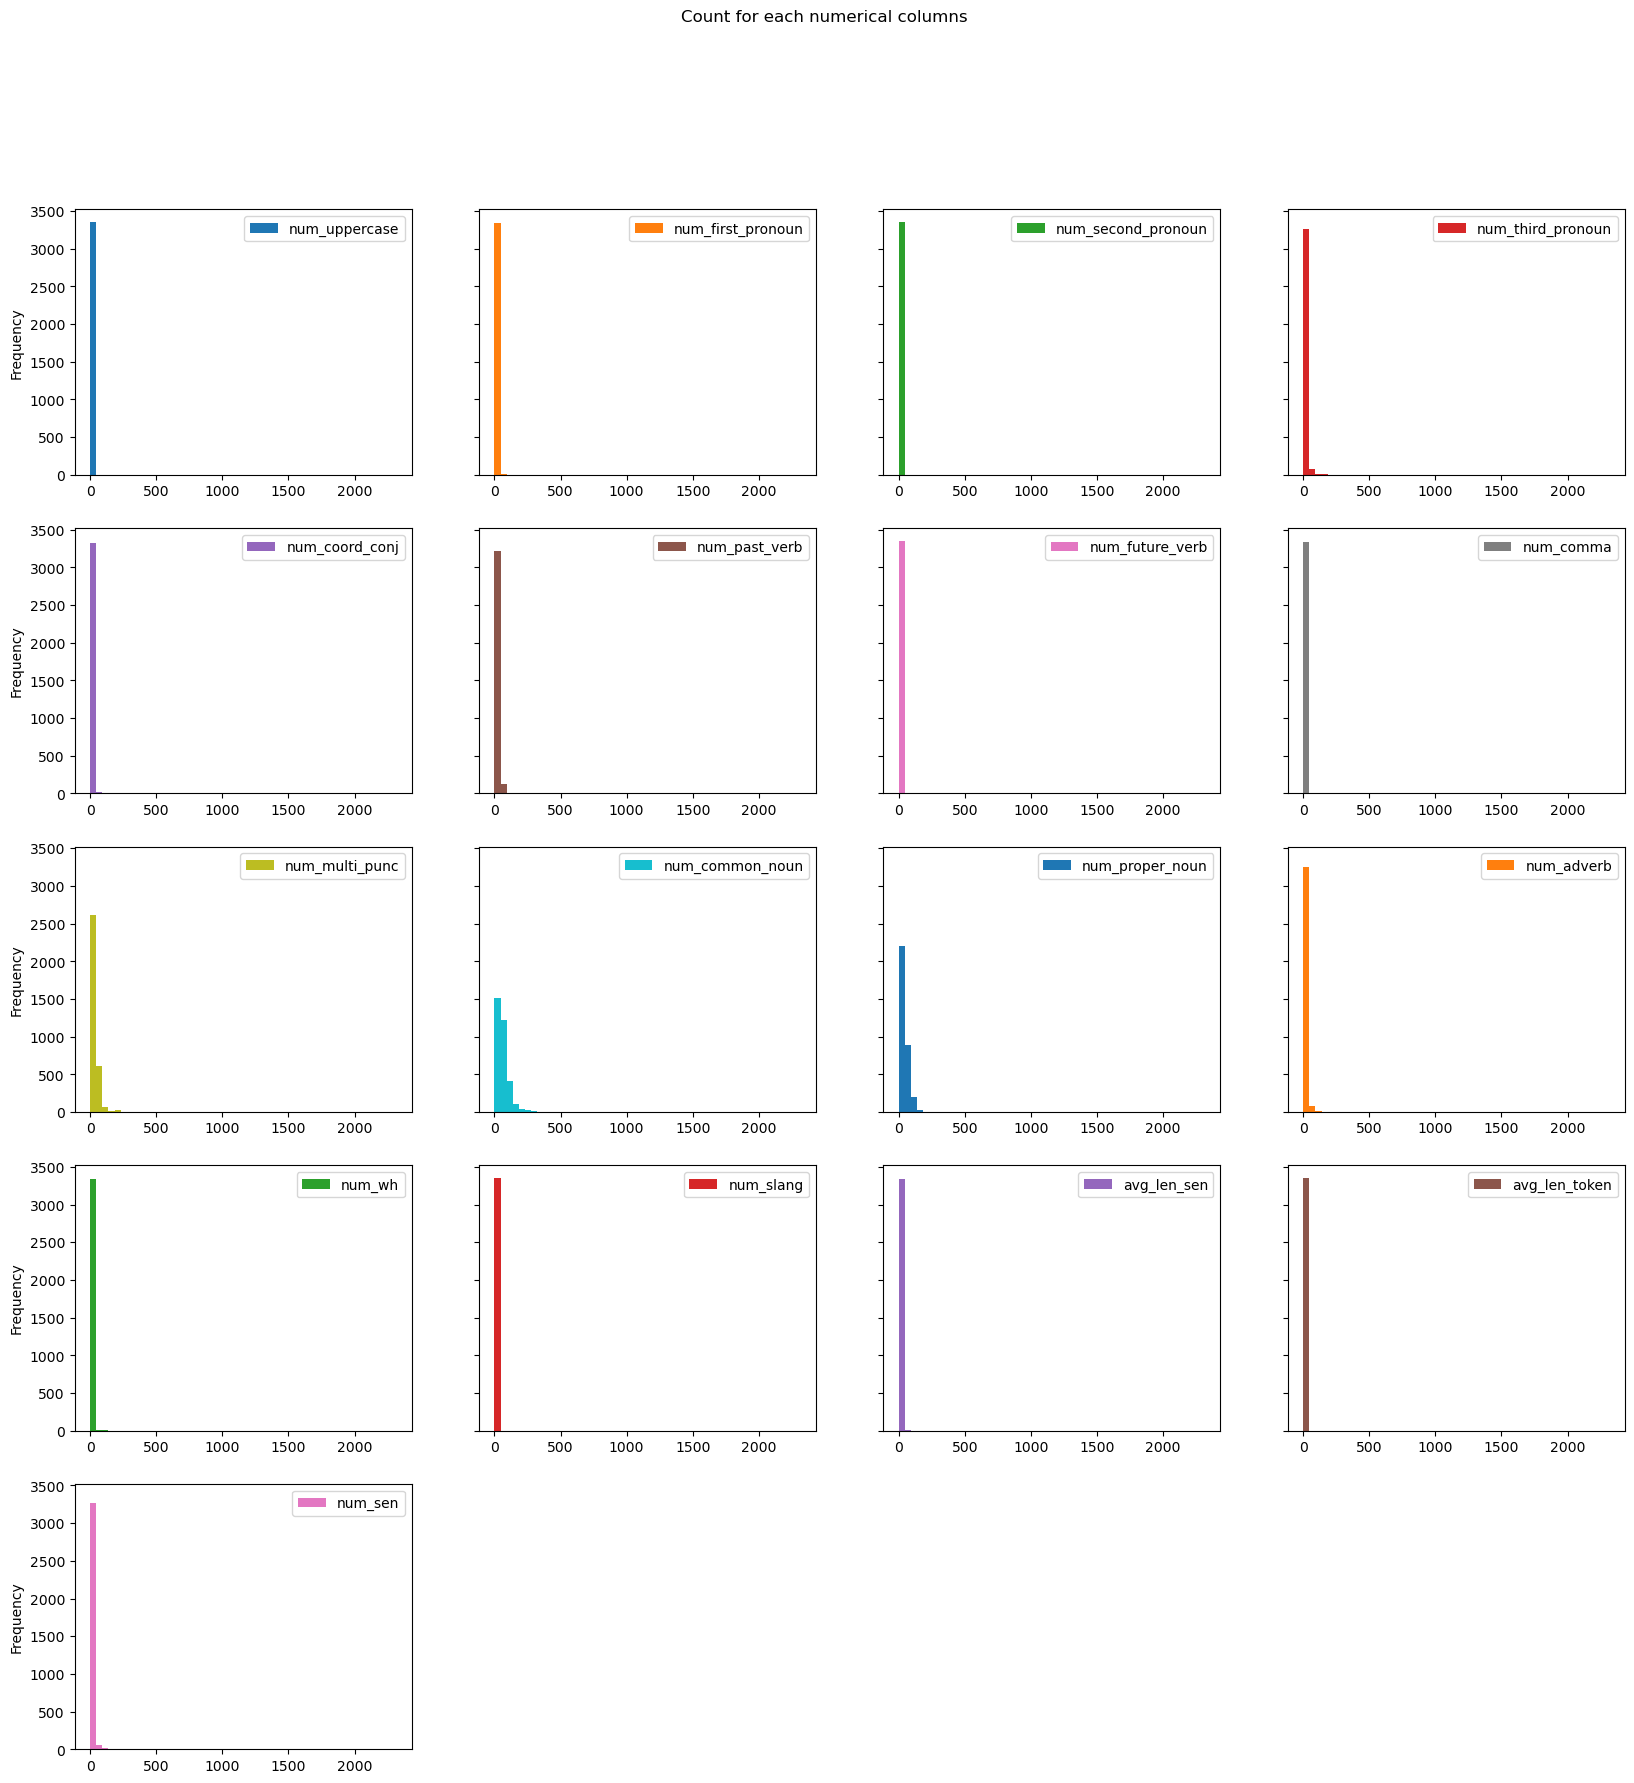

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histgrams
ax = final_df[col].plot(kind='hist',subplots=True,sharex=False,sharey=True,title='Count for each numerical columns', bins=50,grid=False, layout=(5, 4), figsize=(20, 20))

### Count of unique words in the dataframe

The below histogram is displaying the freqency of unique word counts. Notice this plot is also highly right skewed, meaning not a lot of unique words are used in the text data.

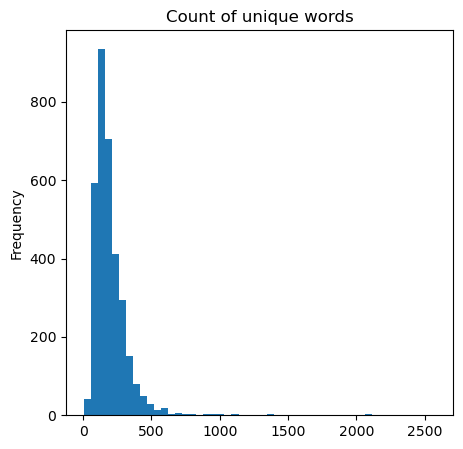

In [3]:
# Unique word histogram
final_df = pd.read_csv("author_sentiment.csv")
final_df['unique_word_count'] = final_df['DOCUMENT'].apply(lambda x: len(set(str(x).split())))
hist_unique = final_df['unique_word_count'].plot(kind='hist', bins=50, grid=False, figsize=(5, 5), title='Count of unique words')

# Convert the DataFrame to a CSV file
file_path = 'author_sentiment_unique.csv'
final_df.to_csv(file_path, index=False)

In [37]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(review for review in final_df.text_cleaned)

  Using cached wordcloud-1.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (548 kB)


### Word Cloud 

The below is a word cloud from the "text" column in the dataframe after removing stopwords. Notice that there are words like "earth", "climate", "change", "CO2", and "planet" that appear a lot in the text dataset. 
For words, "earth", "CO2", and "climate", we found five most frequent words that appear with these words in bigrams. Consider the following.

#### Earth

- Sun: 6
- Atomospher: 5
- Warm: 5
- Mother: 4
- Cause: 3

#### CO2

- Atmosphere: 8
- Level: 8
- Ton: 6
- Release: 4
- Increase: 4

#### Climate

- Change: 74
- Nasa: 13
- Know: 5
- Cause: 4
- Warm: 3

From above, we can observe that people who commented on NASA's climate change posts tend to put words like "warm", "increase", and "cause" together with words, "earth", "CO2", and "climate".

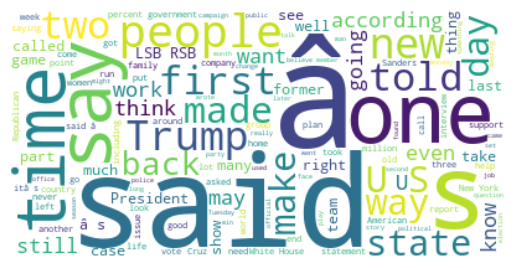

In [38]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["now", "will", "year", "years"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
def bigram_pair(word, bigram):
    """
    word: string
    bigram: df containing a list of bigrams (that is in tuple)
    
    returns a dictionary of counts of word that appeared with given word
    """
    result = {}
    for ind in range(len(bigram)):
        for big in bigram.iloc[ind]:
            big = big.split("_")
            if big[0] == word:
                if (big[1] in result.keys()) and (big[1] not in stopwords):
                    result[big[1]][0] += 1
                elif big[1] not in result.keys():
                    result[big[1]] = [0]
                    result[big[1]][0] +=1
            elif (big[1] == word):
                if (big[0] in result.keys()) and (big[0] not in stopwords):
                    result[big[0]][0] += 1 
                elif big[0] not in result.keys():
                    result[big[0]] = [0]
                    result[big[0]][0] +=1
    result_sorted = sorted(result.items(), reverse=True, key=lambda x: x[1])
    result_sorted = dict(result_sorted)
    result_df = pd.DataFrame(result_sorted)
    return result_df.T
bi_pair = bigram_pair("earth", df["bigram"])
bi_co2 = bigram_pair("co2", df["bigram"])
bi_climate = bigram_pair("climate", df["bigram"])

print(bi_pair.iloc[:5])
print(bi_co2.iloc[:5])
print(bi_climate.iloc[:5])

## Summary

Summary about what you found so far from your data in terms of the formulated question.

In summary, the text data from the "Public Opinion on NASA's Climate Posts on Facebook" is relatively short and the dataframe contains 522 data points. Currently, the numerical columns of the dataframe are very right-skewed and this needs to be corrected in the future. Furthermore, by inspecting the word cloud and the biagram association, there appear to be many words like "earth", "CO2", and "climate" in the text data and people feel words like "warm", "cause", and "increase" associate with these word.

## Prompting ChatGPT for Opinion 

In [8]:
# Randomly sample 20 news article titles and entities 

author_sent = pd.read_csv("author_sentiment.csv")
sample_20 = author_sent.sample(30, replace=False, ignore_index=True)
sample_20_tit_ent = sample_20.loc[:, ['TITLE', 'TARGET_ENTITY']]
print(sample_20_tit_ent.loc[:, 'TITLE'].values)
file_path = 'sample_20_.csv'
sample_20_tit_ent.to_csv(file_path, index=False)

['Hugh Hefner The Founder Of Playboy Has Died At Age 91'
 'City Noise Might Be Making You Sick'
 "In latest twist in Japan election drama Tokyo's Koike says won't seek seat"
 'Bernie Sanders to visit SF on Friday for state nurses convention . '
 'Your Trader Joeâ\x80\x99s salad may contain shards of glass plastic'
 'Marilou Danley Gunmanâ\x80\x99s Girlfriend  Says She Was Unaware of His Plans'
 'How I ditched debt: Setting pride aside and asking for help'
 'Chicago Bears great Joe Fortunato dies at 87'
 'Vinod Khosla opens Martins Beach: PHOTOS'
 "Utah hospital CEO on nurse arrest video: 'This will not happen again'"
 'Ghosthunters grabbers and grifters: What would Jonathan Swift say of our times?'
 'Fowler worries for North Queensland in A-League'
 "Robert Buchel of TLC's 'My 600" 'The Alt' 'Cop mom 5'
 'Factbox: International reaction to arrest of Reuters reporters in Myanmar'
 'UK EU claim Brexit breakthrough; eye talks on future ties'
 'Japan ruling-party heavyweight likely to dodg

In [8]:
# Readin ChatGPT data 
llm_opinion = pd.read_csv("sample_20.csv", encoding='unicode_escape')
llm_opinion

,TITLE,TARGET_ENTITY,response_gpt3,response_gpt4
0,Hugh Hefner The Founder Of Playboy Has Died At...,Hugh M. Hefner,Iconic magazine publisher and cultural provoca...,"Hugh M. Hefner, the iconic founder of Playboy ..."
1,City Noise Might Be Making You Sick,Julia Barnett Rice,Recent research conducted by environmental sci...,The incessant clamor of urban environments is ...
2,In latest twist in Japan election drama Tokyo'...,Kim Kyung-Hoon Koike,"In a surprising turn of events, Tokyo's Govern...",In a surprising development in Japanese politi...
3,Bernie Sanders to visit SF on Friday for state...,Bernie Sanders,Renowned progressive leader and former preside...,Senator Bernie Sanders is scheduled to visit S...
4,Your Trader JoeÃ¢ÂÂs salad may contain shard...,Joe,Shoppers beware: popular grocery chain Trader ...,"In a startling announcement, Trader Joes has ..."
5,Marilou Danley GunmanÃ¢ÂÂs Girlfriend Says ...,Marilou Danley,"Marilou Danley, the former girlfriend of the g...","Marilou Danley, the girlfriend of the gunman r..."
6,How I ditched debt: Setting pride aside and as...,Cara Jesse Nuno,Cara Jesse Nuno's journey from drowning in deb...,"Cara Jesse Nuno, a 34-year-old software develo..."
7,Chicago Bears great Joe Fortunato dies at 87,Joe Fortunato Joe,The football world is mourning the loss of Chi...,"Joe Fortunato, the celebrated linebacker who p..."
8,Vinod Khosla opens Martins Beach: PHOTOS,Vinod Khosla,Tech mogul Vinod Khosla has made headlines onc...,In a significant development for public coasta...
9,Utah hospital CEO on nurse arrest video: 'This...,Alex Wubbels,The CEO of a Utah hospital has responded to pu...,The CEO of University of Utah Hospital publicl...


## Pre-Process ChatGPT's Response

In [13]:
# Process raw text from gpt3
llm_opinion["response_gpt3"] = llm_opinion["response_gpt3"].astype(str)
llm_opinion["text_cleaned"] = llm_opinion["response_gpt3"].apply(lambda x: preprocess(x))
print('Cleaned text')
llm_opinion["text_processed"] = llm_opinion["text_cleaned"].apply(lambda x: pos_tagging(x))
print('POS tagging')
feat_col = ['num_uppercase', 'num_first_pronoun', 'num_second_pronoun', 'num_third_pronoun', 'num_coord_conj', 'num_past_verb', 'num_future_verb', 'num_comma', 'num_multi_punc', 'num_common_noun', 'num_proper_noun', 'num_adverb', 'num_wh', 'num_slang', 'avg_len_sen', 'avg_len_token', 'num_sen']

new_array = np.array([extract(text) for text in llm_opinion['text_processed'].values])
new_df = pd.DataFrame(new_array, columns=feat_col)

# df = pd.concat([llm_opinion, new_df], axis=1)
# df['bigram'] = df['text'].apply(bigram) 

# convert text to tfidf
document = llm_opinion['text_cleaned'].tolist()
tfidf_df = tfidf_vectorize(document)
final_df = pd.concat([new_df, tfidf_df], axis=1)
print("TFIDF vectorized")
print(final_df)

# Convert the DataFrame to a CSV file
file_path = 'response_gpt3.csv'
final_df.to_csv(file_path, index=False)

Cleaned text
POS tagging
TFIDF vectorized
    num_uppercase  num_first_pronoun  num_second_pronoun  num_third_pronoun  \
0             0.0                0.0                 0.0               10.0   
1             0.0                2.0                 0.0                0.0   
2             1.0                0.0                 0.0               12.0   
3             1.0                0.0                 0.0               10.0   
4             0.0                0.0                 0.0                6.0   
5             0.0                1.0                 0.0               11.0   
6             0.0                0.0                 0.0               20.0   
7             2.0                0.0                 0.0               12.0   
8             0.0                0.0                 0.0                3.0   
9             4.0                0.0                 0.0                5.0   
10            0.0                4.0                 0.0                3.0   
11        

In [14]:
# Process raw text from gpt4
llm_opinion["response_gpt4"] = llm_opinion["response_gpt4"].astype(str)
llm_opinion["text_cleaned"] = llm_opinion["response_gpt4"].apply(lambda x: preprocess(x))
print('Cleaned text')
llm_opinion["text_processed"] = llm_opinion["text_cleaned"].apply(lambda x: pos_tagging(x))
print('POS tagging')
feat_col = ['num_uppercase', 'num_first_pronoun', 'num_second_pronoun', 'num_third_pronoun', 'num_coord_conj', 'num_past_verb', 'num_future_verb', 'num_comma', 'num_multi_punc', 'num_common_noun', 'num_proper_noun', 'num_adverb', 'num_wh', 'num_slang', 'avg_len_sen', 'avg_len_token', 'num_sen']

new_array = np.array([extract(text) for text in llm_opinion['text_processed'].values])
new_df = pd.DataFrame(new_array, columns=feat_col)

# df = pd.concat([llm_opinion, new_df], axis=1)
# df['bigram'] = df['text'].apply(bigram) 

# convert text to tfidf
document = llm_opinion['text_cleaned'].tolist()
tfidf_df = tfidf_vectorize(document)
final_df = pd.concat([new_df, tfidf_df], axis=1)
print("TFIDF vectorized")
print(final_df)

# Convert the DataFrame to a CSV file
file_path = 'response_gpt4.csv'
final_df.to_csv(file_path, index=False)

Cleaned text
POS tagging
TFIDF vectorized
    num_uppercase  num_first_pronoun  num_second_pronoun  num_third_pronoun  \
0             0.0                0.0                 0.0               14.0   
1             0.0                0.0                 1.0                4.0   
2             2.0                1.0                 0.0                9.0   
3             2.0                1.0                 0.0                5.0   
4             1.0                4.0                 0.0                9.0   
5             3.0                1.0                 0.0               15.0   
6             0.0                3.0                 0.0               14.0   
7             4.0                0.0                 0.0               17.0   
8             0.0                3.0                 0.0                0.0   
9             2.0                2.0                 0.0                5.0   
10            0.0                4.0                 0.0                8.0   
11        